In this notebook, we attempt to use Dense ANNs on the whole target, as well as on clustered targets to capture relationships for individual drug rows. We use the newX cleaned data from Attempt 1.

In [43]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cluster
import sklearn_extra.cluster
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = np.load("./data/clean_data.npz", allow_pickle=True)
X, Y = data["X"], pd.DataFrame(data["Y"], columns=data["titles"])

<h2> STEP 1 - Full Dense ANN </h2>

In [4]:
nomdl = Y.apply(np.sum)
reltitle = nomdl[nomdl>10].index.values
trainX, testX = X[:15000], X[15000:]
trainY, testY = Y[reltitle].values[:15000], Y[reltitle].values[15000:]
trainX.shape, trainY.shape, testX.shape, testY.shape

((15000, 107), (15000, 184), (8814, 107), (8814, 184))

In [5]:
def dense_model(lossfn="categorical_crossentropy", lr=3e-3, numtargets=trainY.shape[1]):
    tf.keras.backend.clear_session()
    drug = Input((trainX.shape[1],))
    curinp = drug
    for unit, act in [(256,"relu"),(512,"tanh"),(768,"tanh"),(512,"relu")]:
        curinp = Dense(unit, activation=act)(curinp)
        curinp = Dropout(rate=0.15)(curinp)
    final = Dense(numtargets, activation="sigmoid")(curinp)
    mdl = Model(inputs=drug, outputs=final, name="Drug_Classification_ANN")
    mdl.compile(loss=lossfn, optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return mdl
dense_model().summary()

Model: "Drug_Classification_ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 107)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               27648     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               393984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)   

In [6]:
class ImbalanceMSE:
    def __init__(self, weightlst, decayfactor, numepochs):
        self.weightlst = tf.reshape(tf.convert_to_tensor(weightlst, dtype=tf.float32),(1,-1))
        self.decayfactor = decayfactor
        self.numepochs = numepochs
    def loss(self, ytrue, ypred):
        base = tf.cast(ytrue,tf.float32)
        err = tf.math.square(base-ypred)
        err = tf.where(base==1.0,self.weightlst*base,1.0)*err
        return tf.reduce_mean(tf.reduce_sum(err, axis=1))
    def update_weight(self, epoch):
        if (epoch<self.numepochs):
            self.weightlst*=self.decayfactor
            self.weightlst = tf.where(self.weightlst<=1.0,1.0,self.weightlst)
class LossCallBack(tf.keras.callbacks.Callback):
    def __init__(self, lossclass):
        self.lossclass = lossclass
    def on_epoch_end(self, epoch, logs):
        self.lossclass.update_weight(epoch)

In [122]:
lossclass = ImbalanceMSE((trainY.shape[0]-np.sum(trainY,axis=0))/np.sum(trainY,axis=0),0.95,20)
losscallback = LossCallBack(lossclass)
model = dense_model(lossfn=lossclass.loss, lr=2e-3)
hist = model.fit(trainX, trainY, epochs=25, batch_size=128, verbose=False, validation_data=(testX,testY),
                 callbacks=[losscallback])

In [81]:
def neg_log_loss(t,p):
    poslog = np.minimum(np.maximum(np.log(p),np.log(10**(-15))),np.log(1-10**(-15)))
    neglog = np.minimum(np.maximum(np.log(1-p),np.log(10**(-15))),np.log(1-10**(-15)))
    return -np.mean(t*poslog+(1-t)*neglog)
def auc_distribution(t,p):
    auc = collections.deque()
    for i in range(t.shape[1]):
        auc.append(sklearn.metrics.roc_auc_score(t[:,i], p[:,i], average="weighted"))
    return auc
def logloss_distribution(t,p):
    lloss = collections.deque()
    for i in range(t.shape[1]):
        val = neg_log_loss(t[:,i], p[:,i])
        lloss.append(val)
    return lloss

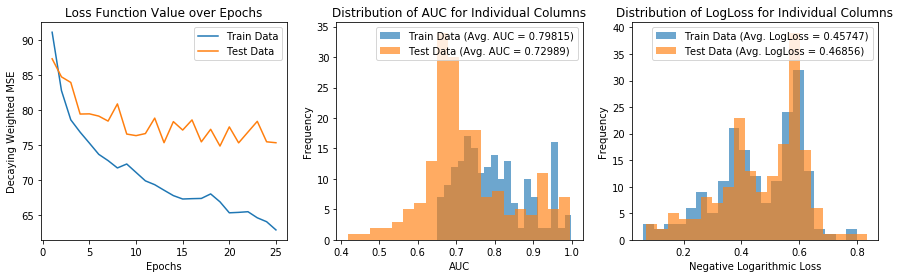

In [189]:
def plotter(hist, trainT, trainP, testT, testP):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    pd.Series(hist["loss"], index=np.arange(len(hist["loss"]))+1).plot(label="Train Data")
    pd.Series(hist["val_loss"], index=np.arange(len(hist["loss"]))+1).plot(label="Test Data")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Decaying Weighted MSE")
    plt.title("Loss Function Value over Epochs")
    plt.subplot(1,3,2)
    trainauc = auc_distribution(trainT, trainP)
    testauc = auc_distribution(testT, testP)
    plt.hist(trainauc, bins=20, alpha=0.65, label="Train Data (Avg. AUC = "+str(round(np.mean(trainauc),5))+")")
    plt.hist(testauc, bins=20, alpha=0.65, label="Test Data (Avg. AUC = "+str(round(np.mean(testauc),5))+")")
    plt.legend(loc="best")
    plt.xlabel("AUC")
    plt.ylabel("Frequency")
    plt.title("Distribution of AUC for Individual Columns")
    plt.subplot(1,3,3)
    #Modification where low-confidence entries are reduced to 0
    testP[testP<=0.5] = 0
    trainP[trainP<=0.5] = 0
    trainloss = logloss_distribution(trainT, trainP)
    testloss = logloss_distribution(testT, testP)
    plt.hist(trainloss, bins=20, alpha=0.65, label="Train Data (Avg. LogLoss = "+
             str(round(np.mean(trainloss),5))+")")
    plt.hist(testloss, bins=20, alpha=0.65, label="Test Data (Avg. LogLoss = "+
             str(round(np.mean(testloss),5))+")")
    plt.legend(loc="best")
    plt.xlabel("Negative Logarithmic Loss")
    plt.ylabel("Frequency")
    plt.title("Distribution of LogLoss for Individual Columns")
plotter(hist.history, trainY, model.predict(trainX), testY, model.predict(testX))

<h2> STEP 2 - Clustering Similar Labels with Unsupervised Learning </h2><br/>
We run PCA on the transpose of the Y prediction table, and then cluster the labels to find groups of similar biological activity that are better suited to be trained on a single dense network.

In [69]:
nomdl = Y.apply(np.sum)
reltitle = nomdl[nomdl>10].index.values
labels = Y[reltitle].T
pca = sklearn.decomposition.PCA(random_state=1).fit(labels)
labels = pca.transform(labels)[:,:35]
kminertia = pd.Series(0, index=np.arange(2,61))
for i in kminertia.index.values:
    km = sklearn.cluster.KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=1).fit(labels)
    kminertia[i] = km.inertia_
csinertia = pd.Series(0, index=np.arange(2,61))
for i in csinertia.index.values:
    cs = sklearn_extra.cluster.KMedoids(n_clusters=i, metric="cosine", init='k-medoids++', max_iter=500,
                                  random_state=1).fit(labels)
    csinertia[i] = cs.inertia_

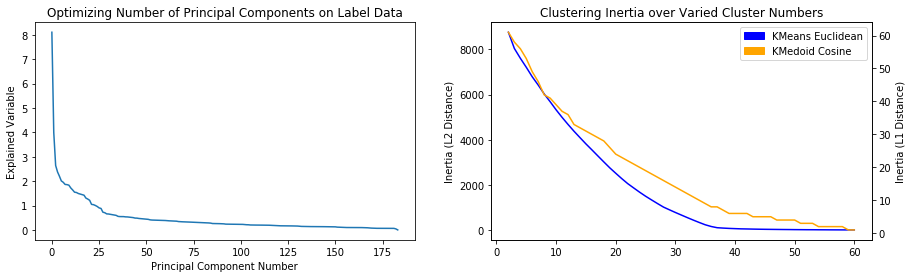

In [70]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(pca.explained_variance_).plot()
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variable")
plt.title("Optimizing Number of Principal Components on Label Data")
ax = plt.subplot(1,2,2)
ax1 = ax.twinx()
kminertia.plot(ax=ax, color="blue")
plt.xlabel("Number of Clusters")
ax.set_ylabel("Inertia (L2 Distance)")
csinertia.plot(ax=ax1, color="orange")
ax1.set_ylabel("Inertia (L1 Distance)")
plt.title("Clustering Inertia over Varied Cluster Numbers")
bptch = mpatches.Patch(color="blue", label="KMeans Euclidean")
optch = mpatches.Patch(color="orange", label="KMedoid Cosine")
plt.legend(handles=[bptch,optch], loc="best")
plt.show()

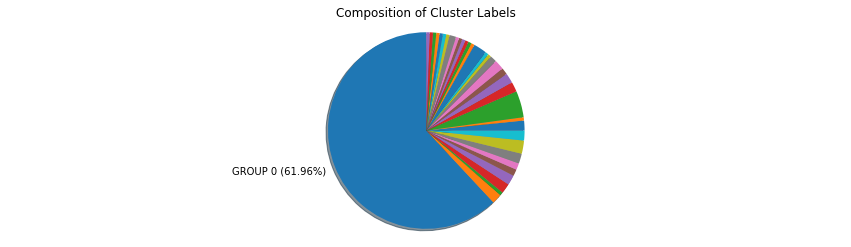

In [71]:
#We choose a 35-cluster KMedoid Cosine from the graph above
km = sklearn_extra.cluster.KMedoids(n_clusters=35, metric="cosine", init='k-medoids++', max_iter=500,
                                  random_state=1).fit(labels)
p = pd.Series(km.labels_).value_counts().sort_index()
titles = np.zeros(p.shape, dtype="<U100")
titles[0] = "GROUP 0 ("+str(round(p.values[0]/np.sum(p)*100,2))+"%)"
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.pie(p.values, labels=titles, shadow=True, startangle=90)
ax.axis('equal')
plt.title("Composition of Cluster Labels")
plt.show()

In [74]:
trainX, testX = X[:15000], X[15000:]
for i in range(35):
    relY = Y[reltitle[km.labels_==i]]
    trainY, testY = relY.values[:15000], relY.values[15000:]
    lossclass = ImbalanceMSE((trainY.shape[0]-np.sum(trainY,axis=0))/np.sum(trainY,axis=0),0.95,20)
    losscallback = LossCallBack(lossclass)
    model = dense_model(lossfn=lossclass.loss, lr=2e-3, numtargets=trainY.shape[1])
    hist = model.fit(trainX, trainY, epochs=25, batch_size=128, verbose=False, validation_data=(testX,testY),
                     callbacks=[losscallback])
    model.save("./models/DenseANN_Label"+str(i)+".h5")
    pickle.dump(hist.history, open("./models/History_Label"+str(i)+".pkl","wb"))

In [77]:
predtrainY = np.zeros((trainX.shape[0],reltitle.shape[0]))
predtestY = np.zeros((testX.shape[0], reltitle.shape[0]))
for i in range(35):
    model = dense_model(lossfn=lossclass.loss, lr=2e-3, numtargets=(reltitle[km.labels_==i]).shape[0])
    model.load_weights("./models/DenseANN_Label"+str(i)+".h5")
    predtrainY[:,km.labels_==i] = model.predict(trainX)
    predtestY[:,km.labels_==i] = model.predict(testX)

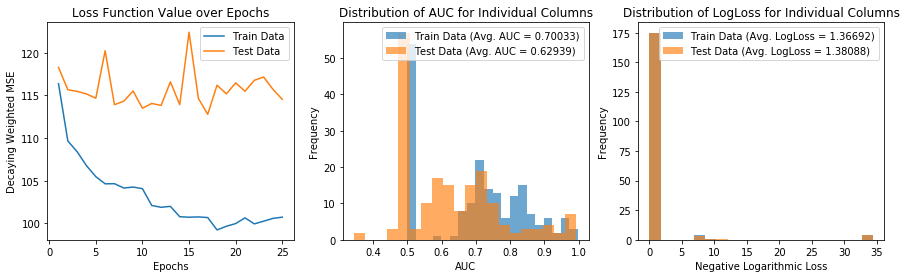

In [87]:
trainY, testY = Y[reltitle].values[:15000], Y[reltitle].values[15000:]
hist = pickle.load(open("./models/History_Label0.pkl","rb"))
for i in range(1,35):
    tp = pickle.load(open("./models/History_Label"+str(i)+".pkl","rb"))
    hist["loss"] = np.array(hist["loss"])+np.array(tp["loss"])
    hist["val_loss"] = np.array(hist["val_loss"])+np.array(tp["val_loss"])
plotter(hist, trainY, predtrainY, testY, predtestY)